# 15. 트랜스포머로 만드는 대화형 챗봇



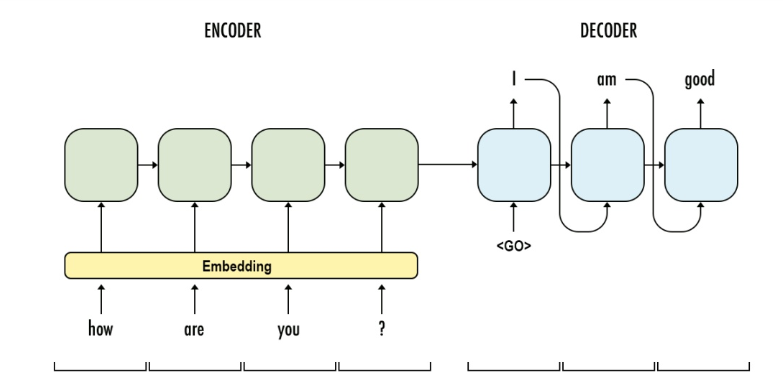


